# Compare Exact Solution to Edge-Density ERGM to Sampler

In [1]:
import Pkg
Pkg.activate("..")

  Activating project at `~/research/xaqlab/ergm.jl`


In [30]:
using ergm.sampler
using ergm.spaces
using ergm.stats
using ergm.models

n = 10
stats = DeltaStats(
    function(G)
        sum(G.adjacency) / (n * (n - 1))
    end,
    function(G, s, u)
        i, x = u
        [s[1] + (x - G[i]) / (n * (n - 1))]
    end
)
m = ExponentialFamily(stats, [0])
G0 = DiGraph(rand(Bool, (n, n)))
s = GibbsSampler(
    G0,
    m,
    10,
    10
)

GibbsSampler(DiGraph(Bool[0 0 … 0 1; 1 0 … 0 0; … ; 0 1 … 0 1; 0 0 … 1 0], 10, 0), DiGraph(Bool[0 0 … 0 1; 1 0 … 0 0; … ; 0 1 … 0 1; 0 0 … 1 0], 10, 0), ExponentialFamily(DeltaStats(var"#43#45"(), var"#44#46"(), 0.5666666666666667, DiGraph(Bool[0 0 … 0 1; 1 0 … 0 0; … ; 0 1 … 0 1; 0 0 … 1 0], 10, 0)), [0]), 10, 10)

In [48]:
using DataFrames
using Statistics

df = DataFrame(θ = Float64[], m = Float64[], r = String[])
θs = map(i -> sign(i) * 10 ^ abs(i), -3:0.1:3)

for θ ∈ θs
    update_params(m, [θ])
    _, ss = sample(s, 10)
    ma = exp(θ / (n * (n - 1))) / (1 + exp(θ / (n * (n - 1))))
    push!(df, (θ, ma, "analytic"))
    push!(df, (θ, mean(ss), "numeric"))
end

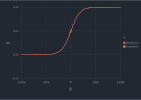

In [49]:
using Gadfly

Gadfly.with_theme(:dark) do
    plot(df, x=:θ, y=:m, color=:r, Geom.line)
end

# Test Burn-In and Autocorrelation for Edge-Triangle

In [28]:
using ergm.models
using ergm.stats
using ergm.sampler
using ergm.spaces
using LinearAlgebra

n = 30
stats = DeltaStats(
    function(G)
        [
            sum(G.adjacency) / (n * (n - 1)),
            tr(G.adjacency ^ 3) / (n * (n - 1) * (n - 2))
        ]
    end,
    function(G, s, u)
        i, x = u
        s + [
            (x - G[i]) / (n * (n - 1)),
            3 * (x - G[i]) * dot(G.adjacency[i[2], :], G.adjacency[:, i[1]]) / (n * (n - 1) * (n - 2))
        ]
    end
)
θ0 = [-20.0, 500.0]
m = ExponentialFamily(stats, θ0)
G0 = DiGraph(rand(Bool, (n, n)))
s = GibbsSampler(G0, m, 0, 1)
Gs, ss = sample(s, 1000)

(Any[DiGraph(Bool[0 1 … 1 0; 0 0 … 0 0; … ; 0 0 … 0 1; 1 0 … 1 0], 30, 0), DiGraph(Bool[0 1 … 1 0; 0 0 … 1 1; … ; 1 0 … 0 0; 1 1 … 1 0], 30, 0), DiGraph(Bool[0 0 … 1 1; 1 0 … 1 1; … ; 0 1 … 0 1; 1 1 … 0 0], 30, 0), DiGraph(Bool[0 1 … 1 1; 1 0 … 0 1; … ; 1 1 … 0 1; 1 1 … 0 0], 30, 0), DiGraph(Bool[0 1 … 0 1; 1 0 … 1 0; … ; 1 0 … 0 0; 0 0 … 1 0], 30, 0), DiGraph(Bool[0 1 … 1 0; 0 0 … 1 1; … ; 1 1 … 0 1; 1 0 … 0 0], 30, 0), DiGraph(Bool[0 1 … 0 1; 1 0 … 1 0; … ; 0 1 … 0 1; 0 1 … 0 0], 30, 0), DiGraph(Bool[0 1 … 1 1; 0 0 … 0 1; … ; 1 1 … 0 1; 0 1 … 0 0], 30, 0), DiGraph(Bool[0 1 … 1 0; 1 0 … 0 0; … ; 1 1 … 0 1; 1 1 … 0 0], 30, 0), DiGraph(Bool[0 0 … 1 1; 1 0 … 1 1; … ; 1 1 … 0 1; 1 1 … 1 0], 30, 0)  …  DiGraph(Bool[0 1 … 0 1; 1 0 … 1 1; … ; 0 1 … 0 1; 1 1 … 1 0], 30, 0), DiGraph(Bool[0 1 … 0 0; 1 0 … 0 0; … ; 1 0 … 0 0; 1 1 … 1 0], 30, 0), DiGraph(Bool[0 1 … 1 1; 1 0 … 1 1; … ; 1 0 … 0 1; 1 1 … 0 0], 30, 0), DiGraph(Bool[0 1 … 1 0; 0 0 … 1 1; … ; 0 1 … 0 1; 1 0 … 0 0], 30, 0), DiGraph(Bool

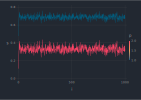

In [37]:
using Gadfly
using DataFrames

df = DataFrame(i = Int[], p = Int[], s = Float64[])
 
for i ∈ 1:length(Gs)
    for p ∈ 1:2
        push!(df, (i, p, ss[p, i]))
    end
end

Gadfly.with_theme(:dark) do
    plot(df, x=:i, y=:s, color=:p, Geom.line)
end

One step of burn-in seems sufficient even when pretty far from Erdös-Renyi for Edge-Triangle model.

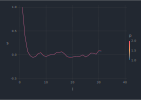

In [36]:
using Gadfly
using DataFrames
using StatsBase

ss_ac = autocor(ss')'
df2 = DataFrame(l = Int[], p = Int[], s = Float64[])
 
for l ∈ 1:size(ss_ac, 2)
    for p ∈ 1:2
        push!(df2, (l, p, ss_ac[p, l]))
    end
end

Gadfly.with_theme(:dark) do
    plot(df2, x=:l, y=:s, color=:p, Geom.line)
end

Ten steps seems sufficient to minimize autocorrelation.

# Test Burn-In and Autocorrelation for Directed Triplet

In [80]:
using ergm.models
using ergm.stats
using ergm.sampler
using ergm.spaces
using LinearAlgebra

n = 30
θ0 = map(p -> sign(p) * 10 ^ abs(p), rand(-3:3, 15))
m = ExponentialFamily(directed_triplet_stats, θ0)
G0 = DiGraph(rand(Bool, (n, n)))
s = GibbsSampler(G0, m, 0, 1)
Gs, ss = sample(s, 1000)

(Any[DiGraph(Bool[0 1 … 0 0; 0 0 … 0 0; … ; 0 1 … 0 1; 1 1 … 0 0], 30, 0), DiGraph(Bool[0 0 … 1 0; 0 0 … 0 0; … ; 1 1 … 0 1; 0 0 … 1 0], 30, 0), DiGraph(Bool[0 0 … 0 0; 1 0 … 0 0; … ; 1 0 … 0 0; 1 1 … 0 0], 30, 0), DiGraph(Bool[0 1 … 0 0; 1 0 … 0 1; … ; 1 1 … 0 1; 1 0 … 0 0], 30, 0), DiGraph(Bool[0 1 … 1 1; 0 0 … 0 1; … ; 0 0 … 0 0; 0 0 … 1 0], 30, 0), DiGraph(Bool[0 0 … 1 0; 1 0 … 1 0; … ; 0 1 … 0 0; 1 0 … 1 0], 30, 0), DiGraph(Bool[0 1 … 1 0; 1 0 … 0 0; … ; 0 0 … 0 1; 1 1 … 0 0], 30, 0), DiGraph(Bool[0 1 … 0 1; 0 0 … 1 1; … ; 1 0 … 0 0; 0 0 … 1 0], 30, 0), DiGraph(Bool[0 0 … 1 0; 0 0 … 1 0; … ; 0 1 … 0 1; 0 1 … 0 0], 30, 0), DiGraph(Bool[0 0 … 0 1; 0 0 … 1 0; … ; 0 0 … 0 0; 0 0 … 0 0], 30, 0)  …  DiGraph(Bool[0 1 … 0 0; 0 0 … 0 0; … ; 0 1 … 0 0; 0 1 … 1 0], 30, 0), DiGraph(Bool[0 1 … 0 1; 1 0 … 1 1; … ; 0 0 … 0 0; 0 0 … 1 0], 30, 0), DiGraph(Bool[0 1 … 1 0; 0 0 … 0 0; … ; 0 0 … 0 0; 1 1 … 0 0], 30, 0), DiGraph(Bool[0 1 … 0 1; 0 0 … 0 1; … ; 0 1 … 0 1; 0 1 … 0 0], 30, 0), DiGraph(Bool

In [163]:
using Gadfly
using DataFrames

ss_b = []

for _ ∈ 1:100
    s = GibbsSampler(G0, m, 0, 1)
    push!(ss_b, sample(s, 20)[2][:, 10:20])
end

ss_b = hcat(ss_b...)

15×1100 Matrix{Float64}:
 0.0149015   0.0157225   0.0180213   …  0.016133    0.0190476   0.01289
 0.00673235  0.00734811  0.0103859      0.0100164   0.00792282  0.00747126
 0.0146552   0.0152709   0.0176108      0.0146141   0.0176929   0.0167077
 0.00812808  0.00915435  0.00775862     0.00821018  0.00915435  0.00812808
 0.00899015  0.00751232  0.00935961     0.00722496  0.00997537  0.00759442
 0.0159688   0.0155583   0.014532    …  0.0114532   0.0179803   0.017734
 0.00562397  0.00545977  0.00496716     0.00381773  0.0070197   0.00656814
 0.0146962   0.0150246   0.0165846      0.0151478   0.01367     0.0141626
 0.0146552   0.0160509   0.0149425      0.0155993   0.0143268   0.0127668
 0.00923645  0.00652709  0.00656814     0.00759442  0.00763547  0.00808703
 0.0155172   0.0143268   0.0123974   …  0.0142036   0.0139573   0.0173645
 0.0070197   0.00779967  0.0066913      0.00726601  0.00706076  0.00964696
 0.00841544  0.00775862  0.00812808     0.0111658   0.00533662  0.00734811
 0.016748

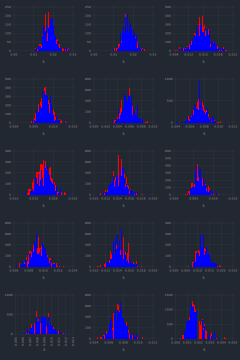

In [164]:
ps = Vector{Plot}()

Gadfly.push_theme(:dark)

for p ∈ 1:15
    df = DataFrame(s = Float64[], b = Int[])

    for i ∈ 1:size(ss, 2)
        push!(df, (ss[p, i], 0))
    end
    
    for i ∈ 1:size(ss_b, 2)
        push!(df, (ss_b[p, i], 1))
    end
    
    push!(ps, plot(
            layer(filter(r -> r.b == 0, df), x=:s, Geom.histogram(density=true), Theme(default_color="blue")),
            layer(filter(r -> r.b == 1, df), x=:s, Geom.histogram(density=true), Theme(default_color="red"))
    ))
end

set_default_plot_size(24cm, 36cm)
gridstack(reshape(ps, (5, 3)))

Ten steps of burn-in seems sufficient even when pretty far from Erdös-Renyi for directed triplet model.

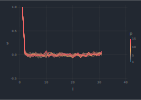

In [83]:
using Gadfly
using DataFrames
using StatsBase

ss_ac = autocor(ss')'
df2 = DataFrame(l = Int[], p = Int[], s = Float64[])
 
for l ∈ 1:size(ss_ac, 2)
    for p ∈ 1:15
        push!(df2, (l, p, ss_ac[p, l]))
    end
end

Gadfly.with_theme(:dark) do
    plot(df2, x=:l, y=:s, color=:p, Geom.line)
end

Ten steps still seems sufficient to minimize autocorrelation.